In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train = pd.read_csv('../inputs/train.csv')
print(train.shape)
test = pd.read_csv('../inputs/test.csv')
print(test.shape)

(8359, 16)
(8360, 11)


In [3]:
def creansing(df_input):
    df_input['User_Score'] = df_input['User_Score'].replace({'nan': np.NaN, 'tbd': np.NaN}).astype(float)
    df_input['User_Count_log'] = df_input['User_Count'].apply(lambda x: np.log1p(x))

In [4]:
creansing(train)
creansing(test)

### label_encode

In [5]:
def get_non_overlapping(train: pd.DataFrame, test: pd.DataFrame, column: str):
    """train/testにしか出てこない値を調べる"""
    only_in_train = set(train[column].unique()) - set(test[column].unique())
    only_in_test = set(test[column].unique()) - set(train[column].unique())
    non_overlapping = only_in_train.union(only_in_test)
    return non_overlapping

def category2num(train: pd.DataFrame, test: pd.DataFrame, columns: list):
    train_ = train.copy()
    test_ = test.copy()
    for column in columns:
        non_overlapping = get_non_overlapping(train, test, column)
        try:
            if train[column].dtype == np.dtype("O"):
                # dtypeがobjectなら欠損は'missing' クラスにする
                train_[column] = train[column].fillna("missing")
                test_[column] = test[column].fillna("missing")
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else "other")
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else "other")
            else:
                # dtypeがint/floatなら欠損は'-1'とする
                train_[column] = train[column].fillna(-1)
                test_[column] = test[column].fillna(-1)
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else -2)
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else -2)

            le = preprocessing.LabelEncoder()
            concatenated = pd.concat([train_, test_], axis=0).reset_index(drop=True)
            le.fit(concatenated[column])
            train_[column] = le.transform(train_[column])
            test_[column] = le.transform(test_[column])
        except Exception:
            import pdb
            pdb.set_trace()
    return train_, test_

In [6]:
def create_label_encoding(df_train, df_test):
    tr, te = category2num(df_train, df_test, ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating'])
    return tr, te

### count_encode

In [7]:
def count_encoding(df_train, df_test, col):
    tr = df_train[col]
    te = df_test[col]
    whole = pd.concat([tr, te])
    vc = whole.value_counts(dropna=False)
    tr_ = pd.DataFrame(tr.map(vc)).add_prefix('CE_')
    te_ = pd.DataFrame(te.map(vc)).add_prefix('CE_')
    return tr_, te_

def create_count_encoding_feature(df_train, df_test):
    tr = pd.DataFrame()
    te = pd.DataFrame()
    for col in ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']:
        tr_, te_ = count_encoding(df_train, df_test, col)
        tr = pd.concat([tr, tr_], axis=1)
        te = pd.concat([te, te_], axis=1)
    return tr, te

In [8]:
def create_feature(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    tr, te = create_count_encoding_feature(train_cp, test_cp)
    train_cp = pd.concat([train_cp, tr], axis=1)
    test_cp = pd.concat([test_cp, te], axis=1)
    
    train_cp, test_cp = create_label_encoding(train_cp, test_cp)
    print('train', train_cp.shape)
    print('test', test_cp.shape)
    assert len(train) == len(train_cp)
    assert len(test) == len(test_cp)
    return train_cp, test_cp

In [9]:
train_, test_ = create_feature(train, test)

train (8359, 22)
test (8360, 17)


In [10]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating
0,LEGO Batman: The Videogame,23,NaN,0,1,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,3.135494,1320,3370,235,77,1420
1,LEGO Indiana Jones: The Original Adventures,23,NaN,0,1,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,3.367296,1320,3370,90,77,1420
2,LEGO Batman: The Videogame,17,NaN,0,1,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,2.397895,1209,3370,235,77,1420
3,Combat,0,NaN,0,1,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,NaN,133,3370,367,6623,6769
4,LEGO Harry Potter: Years 5-7,23,NaN,0,1,69,42,0,12,124,76.0,8.0,7.8,13.0,425,1,2.639057,1320,3370,235,77,1420


In [11]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating
0,Hitman 2: Silent Assassin,26,NaN,0,1,84.0,23.0,8.0,19.0,216,3,2.995732,824,3370,198,20,1563
1,Legacy of Kain: Soul Reaver,13,NaN,0,1,91.0,17.0,9.0,132.0,112,5,4.890349,1197,3370,198,25,2961
2,Metal Gear Solid 2: Substance,26,NaN,0,1,87.0,28.0,8.5,39.0,469,3,3.688879,824,3370,834,12,1563
3,Silent Hill: Homecoming,25,NaN,0,1,70.0,54.0,6.9,180.0,134,3,5.198497,1262,3370,834,22,1563
4,Silent Hill: Homecoming,15,NaN,0,1,71.0,41.0,6.9,143.0,134,3,4.969813,1331,3370,834,22,1563


In [12]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
}

In [13]:
def train_lgbm(X, y, cv, params: dict, verbose=100):

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=verbose)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [14]:
def kfold_lgbm(X, y, param):
    fold = KFold(n_splits=4, shuffle=True, random_state=0)
    cv = list(fold.split(X, y)) 
    oof, models, score = train_lgbm(X, y, cv, params=param)
    return oof, models, score

In [15]:
def train_pred(train_df, y, test_df):
    oof, models, score = kfold_lgbm(train_df, y, lgbm_param)
    
    pred_list = []
    for model in models:
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [16]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [17]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
train_.drop(columns=['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name'], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_)

x_train (6269, 16)
x_valid (2090, 16)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.89069
[200]	valid_0's rmse: 0.883413
[300]	valid_0's rmse: 0.884093
Early stopping, best iteration is:
[246]	valid_0's rmse: 0.882398
Fold 0 Score: 0.8824
x_train (6269, 16)
x_valid (2090, 16)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.920941
[200]	valid_0's rmse: 0.910735
[300]	valid_0's rmse: 0.909987
[400]	valid_0's rmse: 0.909398
Early stopping, best iteration is:
[387]	valid_0's rmse: 0.908307
Fold 1 Score: 0.9083
x_train (6269, 16)
x_valid (2090, 16)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.917464
[200]	valid_0's rmse: 0.904357
[300]	valid_0's rmse: 0.903051
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.902503
Fold 2 Score: 0.9025
x_train (6270, 16)
x_valid (2089, 16)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.913624

In [18]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,sum
15,CE_Publisher,1163,1682,1329,1438,5612
14,Year_of_Release,1003,1604,1202,1344,5153
13,User_Count,586,1018,699,698,3001
12,Critic_Score,542,872,654,643,2711
11,Critic_Count,529,924,627,619,2699
10,Genre,513,774,611,610,2508
7,CE_Developer,471,852,582,588,2493
9,CE_Platform,502,734,584,586,2406
6,User_Score,458,753,612,534,2357
5,Developer,436,720,558,569,2283


In [19]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test)

(8360, 1)
mean= 35.811281054143066
max= 955.301098484882


Text(0.5, 0, 'Global_Sales')

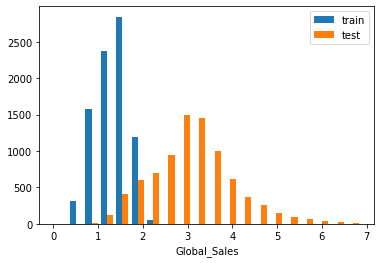

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [21]:
FILENAME = 'submission.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission.csv


In [23]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- score = {:.4f}'.format(score))

- feat = 16
- mean = 35.8113
- max = 955.3011
- score = 0.9007


#### 1: first
- feat = 16
- mean = 35.8113
- max = 955.3011
- score = 0.9007
- LB= 0.9763